EXTRACT ALL DATA

ILE DE FRANCE

In [125]:
import pandas as pd
import json
from shapely.geometry import Point, MultiPolygon, LineString
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Manually construct the relative file path
relative_file_path = "../data/raw/IDF/traces-des-lignes-de-transport-en-commun-idfm.csv"

# Reading the CSV file with pandas
df_paris = pd.read_csv(relative_file_path, sep=';')
print(df_paris.shape)

# Function to transform coordinates
def transform_coordinates(row):
    """
    Convert a DataFrame row with coordinates into multiple rows,
    one for each point in the MultiLineString.
    """
    data_id = row['ID']
    try:
        coordinates = json.loads(row['Shape'])['coordinates']
    except (ValueError, TypeError) as e:
        print(f"Error during JSON conversion for ID {data_id}: {e}")
        return []

    rows_list = []
    for line in coordinates:
        for point in line:
            lon, lat = point
            rows_list.append({
                'ID': data_id,
                'Latitude': lat,
                'Longitude': lon
            })

    return rows_list

# Apply the transformation to each row of the DataFrame
all_rows = []
for _, row in df_paris.iterrows():
    all_rows.extend(transform_coordinates(row))

# Creating a DataFrame from the transformed data
df_paris_transformed = pd.DataFrame(all_rows)

# Convert the columns to numeric data types
df_paris_transformed['Latitude'] = pd.to_numeric(df_paris_transformed['Latitude'])
df_paris_transformed['Longitude'] = pd.to_numeric(df_paris_transformed['Longitude'])

# Rename column from 'ID' to 'shape_id'
df_paris_transformed = df_paris_transformed.rename(columns={'ID': 'shape_id'})

print(df_paris_transformed.head())
print(f"Total rows in DataFrame: {df_paris_transformed.shape[0]}")

(1988, 13)
Error during JSON conversion for ID IDFM:C02383: the JSON object must be str, bytes or bytearray, not float
Error during JSON conversion for ID IDFM:C02460: the JSON object must be str, bytes or bytearray, not float
      shape_id  Latitude  Longitude
0  IDFM:C00029 48.804194   2.601360
1  IDFM:C00029 48.798378   2.605053
2  IDFM:C00029 48.794167   2.604445
3  IDFM:C00029 48.792790   2.604183
4  IDFM:C00029 48.790468   2.603874
Total rows in DataFrame: 164438


GRAND LYON

In [127]:
# Function to extract coordinates from JSON
def extract_coordinates_from_json(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    shape_ids = []
    latitudes = []
    longitudes = []

    # Extract coordinates from JSON data
    for feature in data.get('features', []):
        shape_id = feature['id']
        coordinates = feature['geometry']['coordinates']
        for coord in coordinates:
            if isinstance(coord[0], list):  # Handle nested coordinates
                for sub_coord in coord:
                    longitudes.append(sub_coord[0])
                    latitudes.append(sub_coord[1])
                    shape_ids.append(shape_id)
            else:  # Handle flat coordinates
                longitudes.append(coord[0])
                latitudes.append(coord[1])
                shape_ids.append(shape_id)

    # Create a Pandas DataFrame
    df = pd.DataFrame({
        'shape_id': shape_ids,
        'Latitude': latitudes,
        'Longitude': longitudes
    })

    # Convert columns to ensure correct types
    df['Latitude'] = df['Latitude'].astype(float)
    df['Longitude'] = df['Longitude'].astype(float)

    return df

# List of JSON file paths (relative paths)
file_paths = [
    "../data/raw/GRAND LYON/sytral_lbl_libellule.lblligne.json",
    "../data/raw/GRAND LYON/metropole-de-lyon_cdr_cardurhone.cdrligne.json",
    "../data/raw/GRAND LYON/sytral_rx_rhonexpress.rxligne_2_0_0.json",
    "../data/raw/GRAND LYON/sytral_tcl_sytral.tcllignebus_2_0_0.json",
    "../data/raw/GRAND LYON/sytral_tcl_sytral.tcllignemf_2_0_0.json",
    "../data/raw/GRAND LYON/sytral_tcl_sytral.tcllignetram_2_0_0.json"
]

# Initialize a list to store DataFrames
dfs = []

# Loop to extract data from each JSON file and add to the list
for file_path in file_paths:
    df = extract_coordinates_from_json(file_path)
    dfs.append(df)

# Concatenate all DataFrames into one
df_lyon = pd.concat(dfs, ignore_index=True)

# Show the first few rows of the final DataFrame and total row count
print(df_lyon.head())
print(f"Total rows in combined DataFrame: {df_lyon.shape[0]}")


                      shape_id  Latitude  Longitude
0  lbl_libellule.lblligne.4747 45.980442   4.700001
1  lbl_libellule.lblligne.4747 45.980460   4.700120
2  lbl_libellule.lblligne.4747 45.980480   4.700280
3  lbl_libellule.lblligne.4747 45.980500   4.700450
4  lbl_libellule.lblligne.4747 45.980520   4.700630
Total rows in combined DataFrame: 707669


AIX-MARSEILLE

In [129]:

# Relative file path (adjust according to your directory structure)
file_path = "../data/raw/AIX-MAR/shapes.txt"

# Read the CSV file using pandas
df_am = pd.read_csv(file_path)

# Drop the unnecessary columns
df_am = df_am.drop(columns=["shape_pt_sequence", "shape_dist_traveled"])

# Rename columns
df_am = df_am.rename(columns={
    "shape_pt_lat": "Latitude",
    "shape_pt_lon": "Longitude"
})

# Print the first few rows of the DataFrame
print(df_am.head())

# Print the total number of rows in the DataFrame
print(f"Total rows in DataFrame: {df_am.shape[0]}")

  shape_id  Latitude  Longitude
0   010161 43.295624   5.565080
1   010161 43.295509   5.564389
2   010161 43.295540   5.564290
3   010161 43.295551   5.564220
4   010161 43.295528   5.564170
Total rows in DataFrame: 619495


RE-BALANCE DATAFRAMES

In [131]:
# Define the size of the sample based on the size of df_paris
sample_size = 1000

# Take a random sample from each DataFrame with the size of sample_size
df_lyon_sampled = df_lyon.sample(n=sample_size, random_state=42)  # Ensure reproducibility
df_am_sampled = df_am.sample(n=sample_size, random_state=42)      # Ensure reproducibility
df_paris_sampled = df_paris_transformed.sample(n=sample_size, random_state=42)      # Ensure reproducibility


# Print the first few rows of the sampled DataFrames
print("Sampled Île-de-France DataFrame:")
print(df_paris_sampled.head())

print("\nSampled Lyon DataFrame:")
print(df_lyon_sampled.head())

print("\nSampled Aix-Marseille DataFrame:")
print(df_am_sampled.head())

# Print the total number of rows in the sampled DataFrames
print(f"Total rows in sampled Lyon DataFrame: {df_lyon_sampled.shape[0]}")
print(f"Total rows in sampled Aix-Marseille DataFrame: {df_am_sampled.shape[0]}")

Sampled Île-de-France DataFrame:
           shape_id  Latitude  Longitude
103011  IDFM:C01791 49.148939   1.985348
9237    IDFM:C01480 49.005540   2.096421
159299  IDFM:C02100 48.717903   2.513624
42672   IDFM:C01283 48.840787   2.552644
153699  IDFM:C00556 48.756361   2.526651

Sampled Lyon DataFrame:
                                  shape_id  Latitude  Longitude
616093   tcl_sytral.tcllignebus_2_0_0.30-1 45.658840   4.983790
262843        cdr_cardurhone.cdrligne.3014 46.074605   4.388447
706220  tcl_sytral.tcllignetram_2_0_0.T2-4 45.736076   4.901372
597082  tcl_sytral.tcllignebus_2_0_0.2EX-1 45.754484   4.779316
345866        cdr_cardurhone.cdrligne.3150 45.676280   4.385520

Sampled Aix-Marseille DataFrame:
       shape_id  Latitude  Longitude
258944       44 44.689110   5.685713
248758      428 43.741615   5.072782
572666    SHP62 43.351742   5.473050
476695       93 44.502743   5.764448
366327  6560001 43.386780   5.223279
Total rows in sampled Lyon DataFrame: 1000
Total rows in

In [132]:
# Define the relative path to the GeoJSON file as a string
relative_path = "../data/raw/AIX-MAR/contours-geographiques-metropole.geojson"

# Load the GeoJSON file using the relative path
gdf_aix_marseille = gpd.read_file(relative_path)


# Ensure the geometry column is in the correct format
gdf_aix_marseille = gdf_aix_marseille.set_geometry(gdf_aix_marseille.geometry)

# Convert the sampled DataFrame to a GeoDataFrame
gdf_am_sampled = gpd.GeoDataFrame(
    df_am_sampled, 
    geometry=gpd.points_from_xy(df_am_sampled['Longitude'], df_am_sampled['Latitude']),
    crs="EPSG:4326"  # Assuming the coordinates are in WGS84
)

# Convert Aix-Marseille boundaries to the same CRS as the points
gdf_aix_marseille = gdf_aix_marseille.to_crs(gdf_am_sampled.crs)

# Filter out coordinates not within the Aix-Marseille region
gdf_filtered_am = gdf_am_sampled[gdf_am_sampled.geometry.within(gdf_aix_marseille.union_all())]

# Convert the filtered GeoDataFrame back to pandas DataFrame
df_am_sampled = pd.DataFrame(gdf_filtered_am.drop(columns='geometry'))

# Print the filtered GeoDataFrame
print(df_am_sampled)


        shape_id  Latitude  Longitude
248758       428 43.741615   5.072782
572666     SHP62 43.351742   5.473050
366327   6560001 43.386780   5.223279
336912  60010003 43.523190   5.257900
592617   V060002 43.386780   5.223279
...          ...       ...        ...
613180   V140003 43.472061   5.166081
147073  30520024 43.508114   5.423610
594109   V070015 43.419392   5.237790
387527   6750001 43.400120   5.288830
382481   6740001 43.427979   5.274730

[498 rows x 3 columns]


In [133]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd

# Function to create GeoDataFrame from DataFrame
def create_geodataframe(df, city_name):
    # Create GeoDataFrame with Point geometries
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))

    # Group by shape_id and create LineString for each group
    def create_linestring(group):
        points = group.tolist()
        if len(points) > 1:  # Only create LineString if there are at least 2 points
            return LineString(points)
        else:
            return None  # Return None if there are not enough points to form a LineString

    # Apply the function to each group of shape_id
    gdf = gdf.groupby('shape_id')['geometry'].apply(create_linestring).reset_index()

    # Drop rows where LineString creation failed (e.g., not enough points)
    gdf = gdf[gdf['geometry'].notna()]

    # Convert back to GeoDataFrame
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
    
    print(f"GeoDataFrame created for {city_name} with {gdf.shape[0]} valid routes.")
    return gdf

# Function to check for overlaps between routes and remove them
def check_and_remove_overlaps(gdf, original_df, city_name):
    # Create a set to keep track of indices to drop
    indices_to_drop = set()
    
    for i, route1 in gdf.iterrows():
        for j, route2 in gdf.iloc[i+1:].iterrows():
            if route1['geometry'].intersects(route2['geometry']):
                indices_to_drop.add(route1.name)  # Add index of route1
                indices_to_drop.add(route2.name)  # Add index of route2
    
    # Drop the overlapping routes from the GeoDataFrame
    gdf_cleaned = gdf.drop(index=indices_to_drop).reset_index(drop=True)
    
    # Merge with the original DataFrame to retain Latitude and Longitude
    cleaned_df = original_df[original_df['shape_id'].isin(gdf_cleaned['shape_id'])].reset_index(drop=True)
    
    print(f"Number of overlapping routes in {city_name}: {len(indices_to_drop)}")
    print(f"Remaining routes in {city_name}: {gdf_cleaned.shape[0]}")
    return cleaned_df

# Create GeoDataFrame for each city
gdf_paris = create_geodataframe(df_paris_sampled, "Grand Paris")
gdf_lyon = create_geodataframe(df_lyon_sampled, "GRand Lyon")
gdf_am = create_geodataframe(df_am_sampled, "Aix-Marseille")

# Apply for each city and get cleaned DataFrames including Latitude and Longitude
df_paris_cleaned = check_and_remove_overlaps(gdf_paris, df_paris_sampled, "Grand Paris")
df_lyon_cleaned = check_and_remove_overlaps(gdf_lyon, df_lyon_sampled, "Grand Lyon")
df_am_cleaned = check_and_remove_overlaps(gdf_am, df_am_sampled, "Aix-Marseille")

# Display the cleaned DataFrames in the desired format
print("Cleaned Île-de-France DataFrame:")
print(df_paris_cleaned.head())

print("\nCleaned Lyon DataFrame:")
print(df_lyon_cleaned.head())

print("\nCleaned Aix-Marseille DataFrame:")
print(df_am_cleaned.head())


GeoDataFrame created for Grand Paris with 205 valid routes.
GeoDataFrame created for GRand Lyon with 243 valid routes.
GeoDataFrame created for Aix-Marseille with 119 valid routes.
Number of overlapping routes in Grand Paris: 27
Remaining routes in Grand Paris: 178
Number of overlapping routes in Grand Lyon: 75
Remaining routes in Grand Lyon: 168
Number of overlapping routes in Aix-Marseille: 49
Remaining routes in Aix-Marseille: 70
Cleaned Île-de-France DataFrame:
      shape_id  Latitude  Longitude
0  IDFM:C01480 49.005540   2.096421
1  IDFM:C00245 49.053471   2.685866
2  IDFM:C02138 48.918354   2.659433
3  IDFM:C01140 48.792982   2.510324
4  IDFM:C01413 48.838183   2.356230

Cleaned Lyon DataFrame:
                             shape_id  Latitude  Longitude
0   tcl_sytral.tcllignebus_2_0_0.30-1 45.658840   4.983790
1  tcl_sytral.tcllignetram_2_0_0.T2-4 45.736076   4.901372
2        cdr_cardurhone.cdrligne.3181 45.617340   4.553840
3    tcl_sytral.tcllignebus_2_0_0.3-5 45.808954   4.7

In [134]:
import pyproj
from shapely.geometry import Point
from shapely.ops import transform

# Function to create LineString objects for each group of shape_id
def create_linestrings(df):
    lines = []
    
    # Group the dataframe by shape_id and aggregate Latitude and Longitude
    df_grouped = df.groupby("shape_id").agg({
        'Latitude': list,
        'Longitude': list
    }).reset_index()
    
    for _, row in df_grouped.iterrows():
        shape_id = row['shape_id']
        lat_list = row['Latitude']
        lon_list = row['Longitude']
        
        # Ensure there are enough points to create a valid LineString
        if len(lat_list) > 1 and len(lon_list) > 1:
            points = [Point(lon, lat) for lon, lat in zip(lon_list, lat_list)]
            line = LineString(points)
            lines.append((shape_id, line))  # Store shape_id and LineString
        
    return lines

# Function to calculate the distance in kilometers of a LineString
def calculate_distance(line):
    # Project the line from WGS 84 (EPSG:4326) to Web Mercator (EPSG:3857) for accurate distance calculation
    project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True).transform
    line_proj = transform(project, line)
    return line_proj.length / 1000  # Convert meters to kilometers

# Function to calculate total commercial kilometers for each dataset
def compute_commercial_km(lines):
    total_distance_km = sum(calculate_distance(line) for shape_id, line in lines)
    return total_distance_km

# Ensure columns are correctly typed as float
def ensure_floats(df):
    df['Latitude'] = df['Latitude'].astype(float)
    df['Longitude'] = df['Longitude'].astype(float)
    return df

# Ensure the datasets are in the correct format
df_paris_cleaned = ensure_floats(df_paris_cleaned)
df_lyon_cleaned = ensure_floats(df_lyon_cleaned)
df_am_cleaned = ensure_floats(df_am_cleaned)

# Create LineString objects for each dataset
lines_paris = create_linestrings(df_paris_cleaned)
lines_lyon = create_linestrings(df_lyon_cleaned)
lines_aix_marseille = create_linestrings(df_am_cleaned)

# Calculate commercial kilometers for each dataset
commercial_km_paris = compute_commercial_km(lines_paris)
commercial_km_lyon = compute_commercial_km(lines_lyon)
commercial_km_aix_marseille = compute_commercial_km(lines_aix_marseille)

# Display commercial kilometers for each region
print(f"Commercial kilometers for Île-de-France: {commercial_km_paris} km")
print(f"Commercial kilometers for Lyon: {commercial_km_lyon} km")
print(f"Commercial kilometers for Aix-Marseille: {commercial_km_aix_marseille} km")


Commercial kilometers for Île-de-France: 2194.0909628764025 km
Commercial kilometers for Lyon: 1405.5298530150878 km
Commercial kilometers for Aix-Marseille: 482.074333948317 km


CONCAT ALL THE DB

In [136]:
# Add the 'Location' column to each DataFrame using Pandas' assign method
df_am_cleaned = df_am_sampled.assign(Location="Aix-Marseille")

df_paris_cleaned = df_paris_sampled.assign(Location="Grand Paris")

df_lyon_cleaned = df_lyon_sampled.assign(Location="Grand Lyon")


In [137]:
# Concatenate all DataFrames into one using Pandas' concat
df_combined = pd.concat([df_am_cleaned, df_lyon_cleaned, df_paris_cleaned], ignore_index=True)

# Display the combined DataFrame
print(df_combined)

# Get unique locations from the 'Location' column
unique_locations = df_combined['Location'].unique()
print(unique_locations)


         shape_id  Latitude  Longitude       Location
0             428 43.741615   5.072782  Aix-Marseille
1           SHP62 43.351742   5.473050  Aix-Marseille
2         6560001 43.386780   5.223279  Aix-Marseille
3        60010003 43.523190   5.257900  Aix-Marseille
4         V060002 43.386780   5.223279  Aix-Marseille
...           ...       ...        ...            ...
2493  IDFM:C00116 49.008983   1.926034    Grand Paris
2494  IDFM:C00764 49.050720   2.041076    Grand Paris
2495  IDFM:C02040 48.968511   2.194112    Grand Paris
2496  IDFM:C01479 48.997606   2.108107    Grand Paris
2497  IDFM:C01679 48.897717   2.329564    Grand Paris

[2498 rows x 4 columns]
['Aix-Marseille' 'Grand Lyon' 'Grand Paris']


In [170]:
# Export the DataFrame to CSV format with a relative path
df_combined.to_csv(path_or_buf='../data/clean/df_final.csv', index=False)


ADDITIONNAL DATA

In [238]:
import numpy as np
from scipy.stats import ttest_ind

# Provided demographic and transportation data with additional indicators
data = { 
    'Indicator': [
        'Population', 'Surface (km²)', 'Density (people/km²)', 
        'Commercial kilometers (km²)', 'Commercial kilometers / inhabitant', 
        'Number of cars', 'Volume of cars per inhabitant',
        'Number of routes', 'Number of overlapping routes'
    ],
    'Aix-Marseille': [1831500, 3173, 1831500 / 3173, 482, 482 / 1831500, 1265189, 1265189 / 1831500, 150, 20],
    'Grand Paris': [7200000, 814, 7200000 / 814, 2194, 2194 / 7200000, 4600000, 4600000 / 7200000, 300, 40],
    'Grand Lyon': [1400000, 538, 1400000 / 538, 1405, 1405 / 1400000, 600000, 600000 / 1400000, 180, 25]
}

# Convert the data dictionary to a pandas DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to long format
df_melted = df.melt(id_vars="Indicator", var_name="Region", value_name="Value")

# Pivot the DataFrame for easier comparison
df_pivoted = df_melted.pivot(index='Indicator', columns='Region', values='Value')

# Save the extended dataset to a CSV file with a relative path
relative_path = "../data/clean/extended_efficiency_metrics.csv"
df_pivoted.to_csv(relative_path, index=False)

HYPHOTHESIS TESTING

In [240]:
# Filter out necessary metrics to test the hypothesis
efficiency_metrics = df_melted[df_melted['Indicator'].isin(['Commercial kilometers (km²)', 'Number of routes', 'Number of overlapping routes', 'Surface (km²)'])]

# Pivot the DataFrame for easier comparison
df_pivoted = efficiency_metrics.pivot(index='Indicator', columns='Region', values='Value')

# Simulate extended data for testing (e.g., by creating synthetic variations around existing values)
def simulate_data(df_pivoted, n_points):
    extended_data = []
    np.random.seed(42)
    for indicator in df_pivoted.index:
        for region in df_pivoted.columns:
            base_value = df_pivoted.loc[indicator, region]
            simulated_values = base_value + np.random.normal(scale=0.1 * base_value, size=n_points)
            extended_data.extend([(region, indicator, val) for val in simulated_values])
    return pd.DataFrame(extended_data, columns=['Region', 'Indicator', 'Value'])

# Generate simulated data
extended_data = simulate_data(df_pivoted, 30)


# Ensure columns are correctly typed as numeric in extended_data
extended_data['Value'] = pd.to_numeric(extended_data['Value'])

# Perform T-tests to compare regions using simulated data
print("\nT-test results (with simulated data):")
for indicator in df_pivoted.index:
    aix_marseille_data = extended_data[(extended_data['Region'] == 'Aix-Marseille') & (extended_data['Indicator'] == indicator)]['Value']
    grand_paris_data = extended_data[(extended_data['Region'] == 'Grand Paris') & (extended_data['Indicator'] == indicator)]['Value']
    grand_lyon_data = extended_data[(extended_data['Region'] == 'Grand Lyon') & (extended_data['Indicator'] == indicator)]['Value']
    
    ttest_aix_paris = ttest_ind(aix_marseille_data, grand_paris_data)
    ttest_aix_lyon = ttest_ind(aix_marseille_data, grand_lyon_data)
    ttest_paris_lyon = ttest_ind(grand_paris_data, grand_lyon_data)
    
    print(f"\n{indicator}:")
    print(f"Aix-Marseille vs Grand Paris: t-statistic = {ttest_aix_paris.statistic:.2f}, p-value = {ttest_aix_paris.pvalue:.4f}")
    print(f"Aix-Marseille vs Grand Lyon: t-statistic = {ttest_aix_lyon.statistic:.2f}, p-value = {ttest_aix_lyon.pvalue:.4f}")
    print(f"Grand Paris vs Grand Lyon: t-statistic = {ttest_paris_lyon.statistic:.2f}, p-value = {ttest_paris_lyon.pvalue:.4f}")


# Interpretation
threshold = 0.05
if (ttest_aix_paris.pvalue < threshold) or (ttest_aix_lyon.pvalue < threshold) or (ttest_paris_lyon.pvalue < threshold):
    print("\nThe p-values indicate a significant difference in public transportation efficiency between some regions. Thus, the hypothesis may not hold.")
else:
    print("\nThe p-values indicate no significant difference in public transportation efficiency between the regions. Thus, the hypothesis holds.")


T-test results (with simulated data):

Commercial kilometers (km²):
Aix-Marseille vs Grand Paris: t-statistic = -42.55, p-value = 0.0000
Aix-Marseille vs Grand Lyon: t-statistic = -36.36, p-value = 0.0000
Grand Paris vs Grand Lyon: t-statistic = 17.45, p-value = 0.0000

Number of overlapping routes:
Aix-Marseille vs Grand Paris: t-statistic = -27.57, p-value = 0.0000
Aix-Marseille vs Grand Lyon: t-statistic = -8.38, p-value = 0.0000
Grand Paris vs Grand Lyon: t-statistic = 19.58, p-value = 0.0000

Number of routes:
Aix-Marseille vs Grand Paris: t-statistic = -20.76, p-value = 0.0000
Aix-Marseille vs Grand Lyon: t-statistic = -6.69, p-value = 0.0000
Grand Paris vs Grand Lyon: t-statistic = 15.94, p-value = 0.0000

Surface (km²):
Aix-Marseille vs Grand Paris: t-statistic = 44.48, p-value = 0.0000
Aix-Marseille vs Grand Lyon: t-statistic = 49.34, p-value = 0.0000
Grand Paris vs Grand Lyon: t-statistic = 19.40, p-value = 0.0000

The p-values indicate a significant difference in public tra

VISUALIZATION

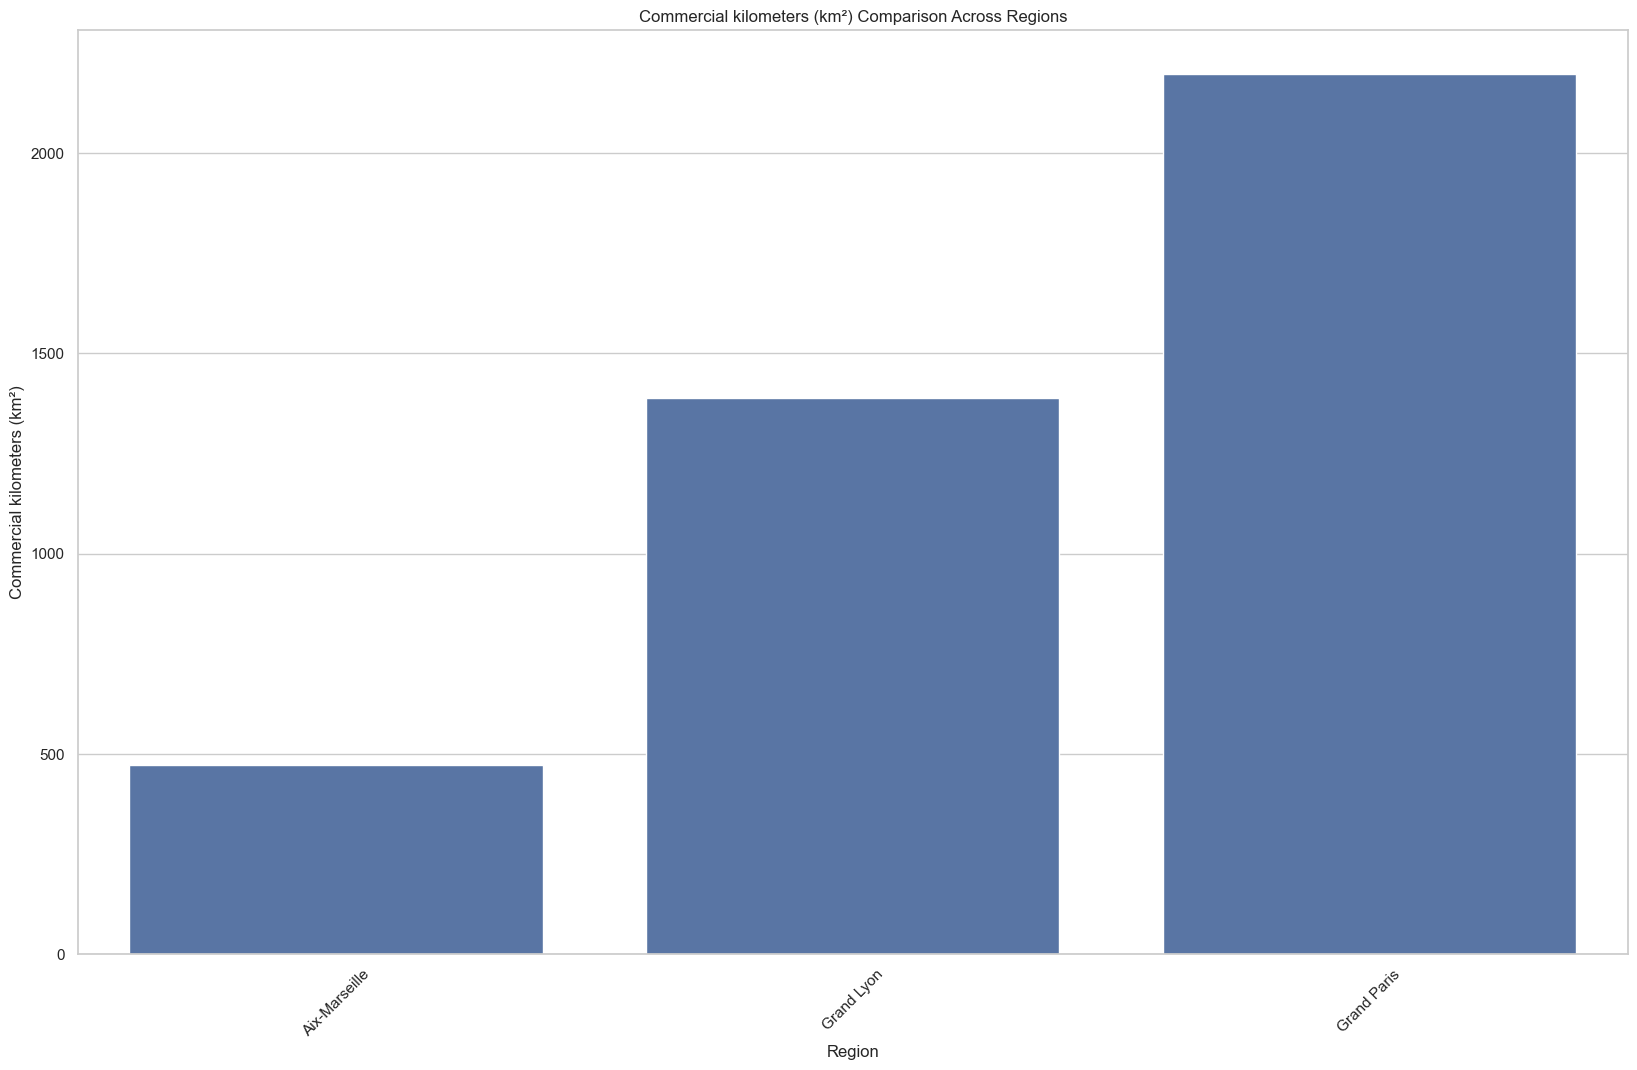

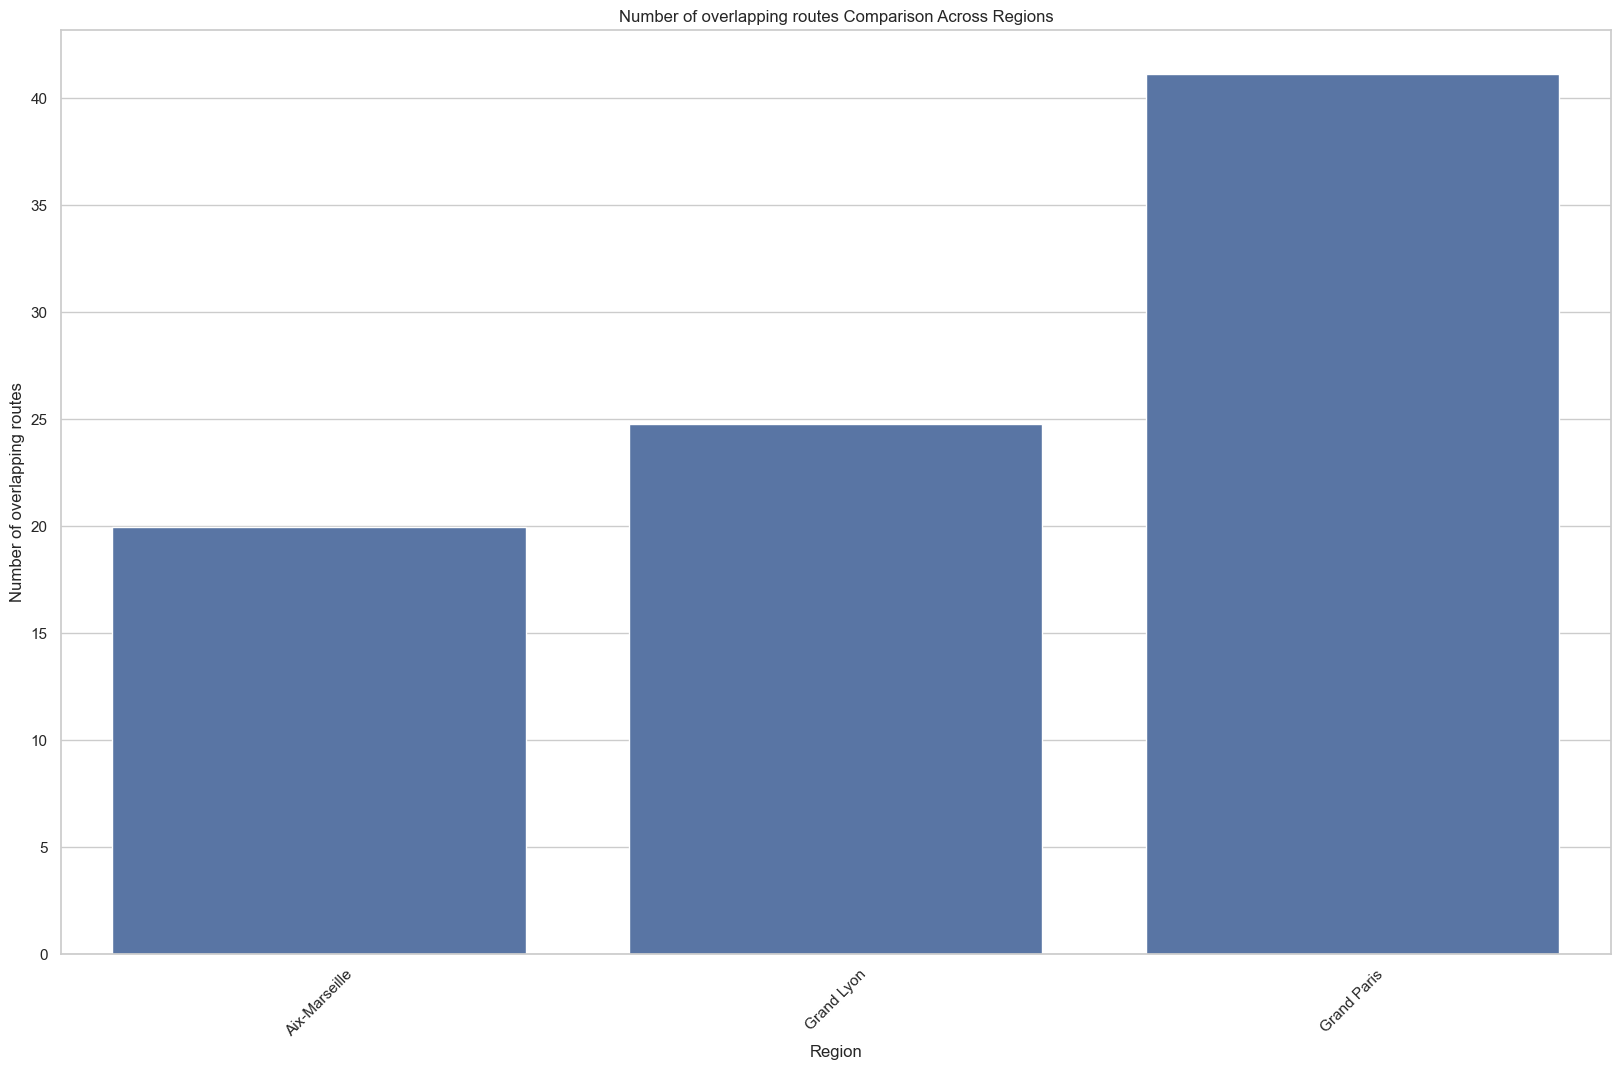

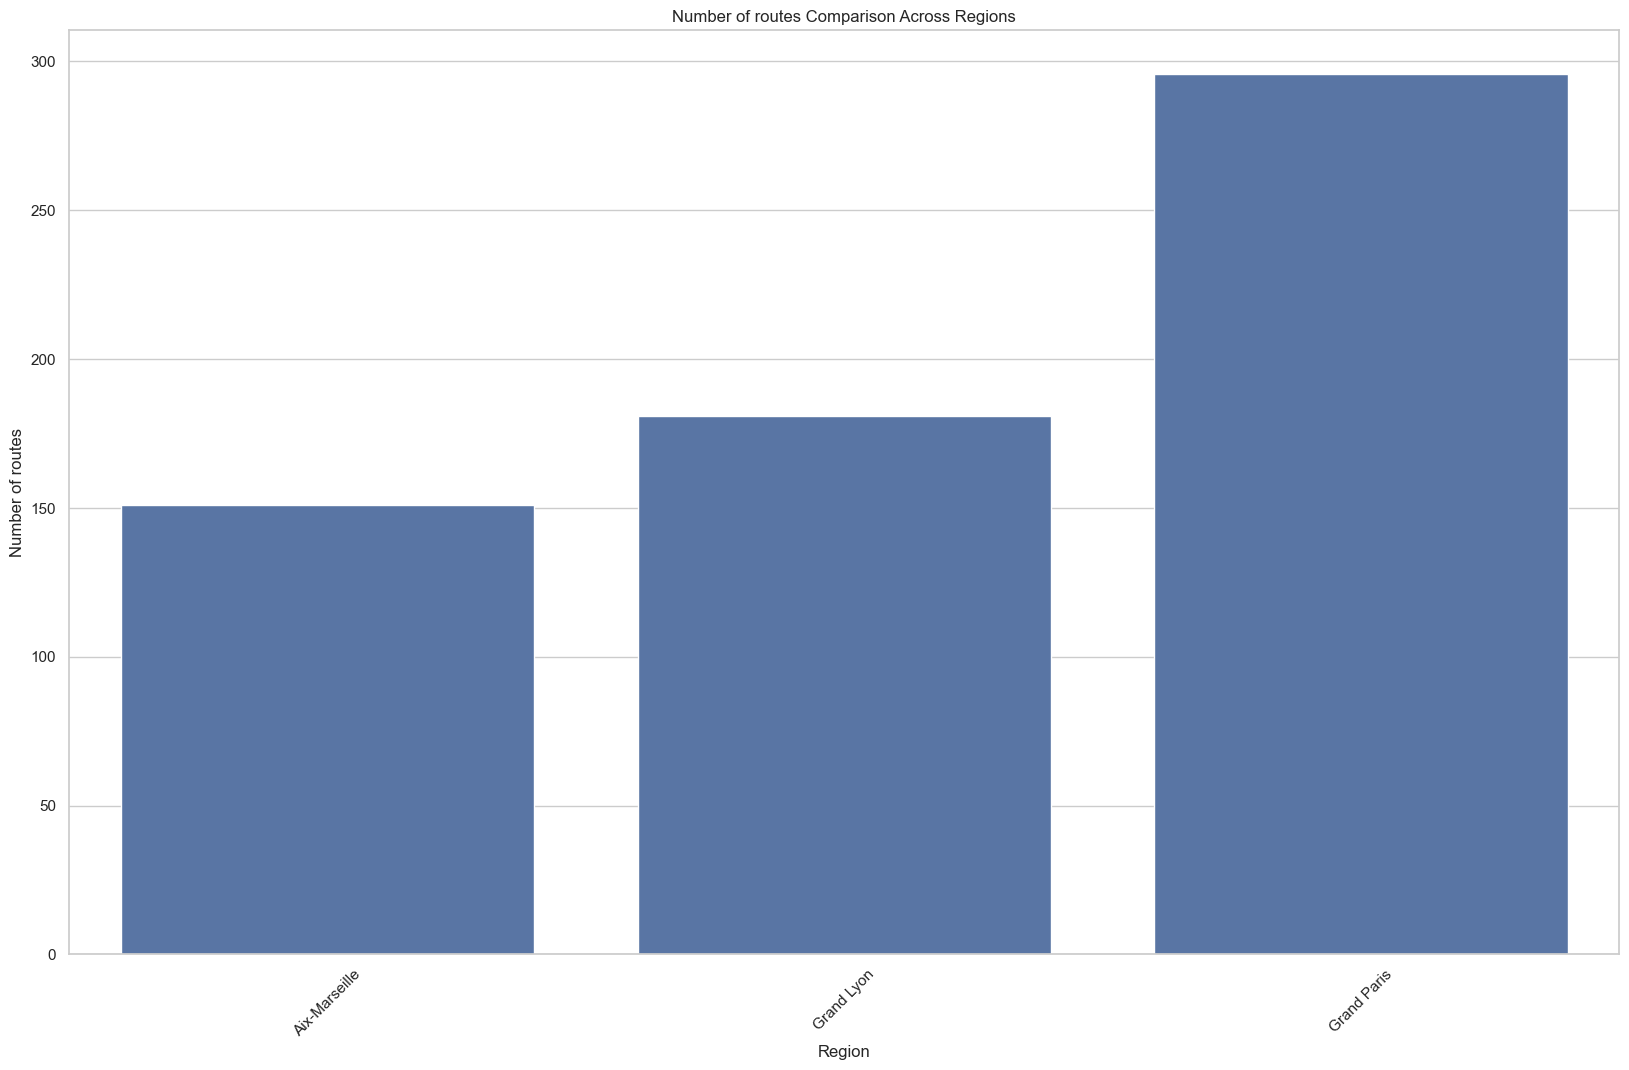

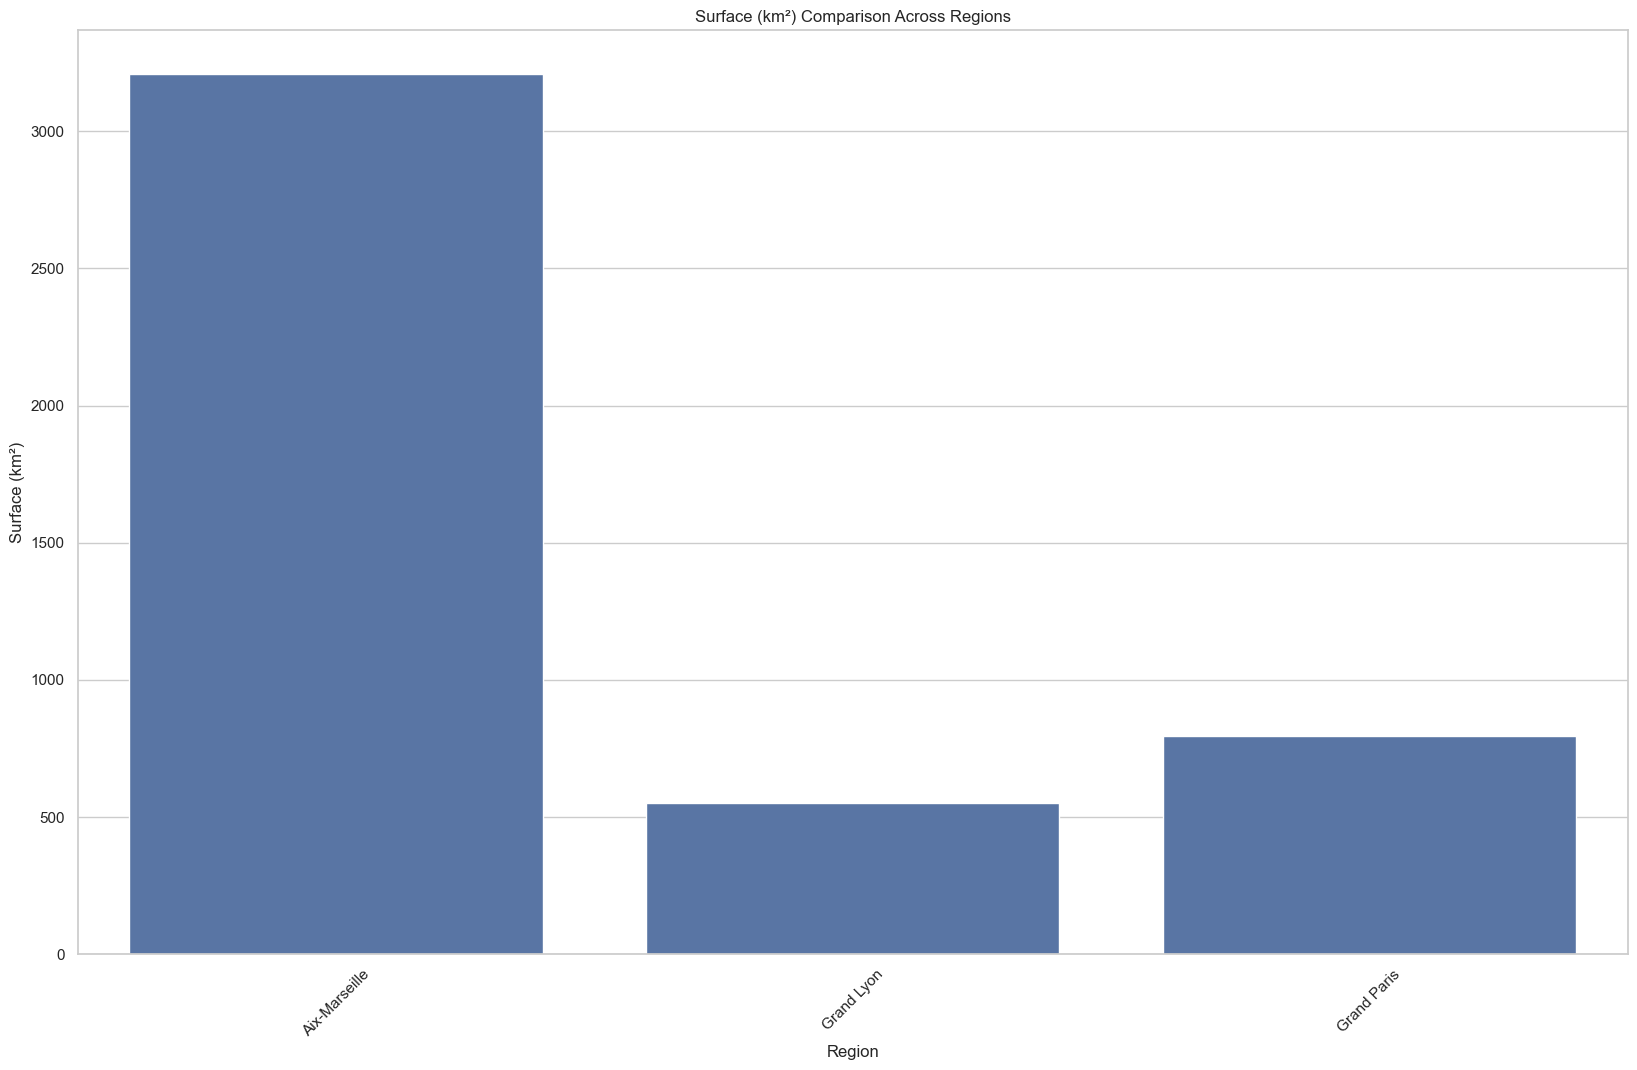

In [248]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for seaborn
sns.set(style="whitegrid")

# Pivot the extended_data for visualization
extended_data_pivoted = extended_data.pivot_table(index='Indicator', columns='Region', values='Value', aggfunc='mean')

# Function to visualize the data for each indicator
def visualize_indicators(df):
    indicators = df.index
    for indicator in indicators:
        plt.figure(figsize=(20, 12))
        # Extract data as numpy array and ensure correct data type
        x_labels = df.columns.tolist()  # Regions as x-labels
        y_values = df.loc[indicator].astype('float64').values  # Values for y-axis
        
        # Create barplot
        sns.barplot(x=x_labels, y=y_values)
        
        # Set title and labels
        plt.title(f'{indicator} Comparison Across Regions')
        plt.xlabel('Region')
        plt.ylabel(indicator)
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.show()

# Visualize the indicators
visualize_indicators(extended_data_pivoted)


Documentation
Shapes transportation network : 
- paris : https://data.iledefrance-mobilites.fr/explore/dataset/traces-des-lignes-de-transport-en-commun-parism/information/?disjunctive.route_type
- Aix - Marseille : https://www.data.gouv.fr/fr/datasets/reseaux-de-transports-en-commun-de-la-metropole-daix-marseille-provence-et-des-bouches-du-rhone/#/resources
- Grand Lyon : https://data.grandlyon.com/portail/fr/jeux-de-donnees/reseau-transport-commun-lyonnais/info

KPI for evaluation transportation network performance : https://temis.documentation.developpement-durable.gouv.fr/docs/Temis/0060/Temis-0060704/16933.pdf

Aix - Marseille metropole boundaries : https://data.ampmetropole.fr/explore/dataset/contours-geographiques-metropole/export/
paris metropole boundaries : https://data.iledefrance.fr/explore/dataset/geoflar-departements/information/
Grand Lyon metropole boundaries : https://data.grandlyon.com/portail/fr/jeux-de-donnees/communes-de-la-metropole-de-lyon--a-partir-de-2024/info

df_contexte data : https://www.insee.fr/



### 